In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
# Imports...
import matplotlib.pyplot as mp

In [3]:
# get all data
sales_train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
item_cat = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

# Overview of data
## Sales train

In [4]:
sales_train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [5]:
sales_train.info

<bound method DataFrame.info of                date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1

## Items

In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
items.info

<bound method DataFrame.info of                                                item_name  item_id  \
0              ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      !ABBYY FineReader 12 Professional Edition Full...        1   
2          ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3        ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4            ***КОРОБКА (СТЕКЛО)                       D        4   
...                                                  ...      ...   
22165             Ядерный титбит 2 [PC, Цифровая версия]    22165   
22166    Язык запросов 1С:Предприятия  [Цифровая версия]    22166   
22167  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...    22167   
22168                                Яйцо для Little Inu    22168   
22169                      Яйцо дракона (Игра престолов)    22169   

       item_category_id  
0                    40  
1                    76  
2                    40  
3                    40  
4        

## Item Categories

In [8]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
item_cat.info

<bound method DataFrame.info of            item_category_name  item_category_id
0     PC - Гарнитуры/Наушники                 0
1            Аксессуары - PS2                 1
2            Аксессуары - PS3                 2
3            Аксессуары - PS4                 3
4            Аксессуары - PSP                 4
..                        ...               ...
79                  Служебные                79
80         Служебные - Билеты                80
81    Чистые носители (шпиль)                81
82  Чистые носители (штучные)                82
83           Элементы питания                83

[84 rows x 2 columns]>

## Shops

In [10]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## Check Null values
Conclusion: No value is missing or null.

In [12]:
print(sales_train.isnull().mean())
print()
print(items.isnull().mean())
print()
print(item_cat.isnull().mean())
print()
print(item_cat.isnull().mean())
print()
print(shops.isnull().mean())

date              0.0
date_block_num    0.0
shop_id           0.0
item_id           0.0
item_price        0.0
item_cnt_day      0.0
dtype: float64

item_name           0.0
item_id             0.0
item_category_id    0.0
dtype: float64

item_category_name    0.0
item_category_id      0.0
dtype: float64

item_category_name    0.0
item_category_id      0.0
dtype: float64

shop_name    0.0
shop_id      0.0
dtype: float64


## Let's see at how many different values we are dealing with
Conclusions:
1. There is no redundant item/item_category/shop id
1. There is no redundant item/item_category/shop name

In [13]:
print(items['item_id'].unique().size == items.shape[0])
print(items['item_name'].unique().size == items.shape[0])
print(item_cat['item_category_id'].unique().size == item_cat.shape[0])
print(item_cat['item_category_name'].unique().size == item_cat.shape[0])
print(shops['shop_id'].unique().size == shops.shape[0])

True
True
True
True
True


## Some high level analysis

In [14]:
# Average # of times an item is sold
print('Average of # of times an item is sold : ', sales_train.shape[0] / items.shape[0])

Average of # of times an item is sold :  132.42440234551196


## Visualization of sales per item_id

In [15]:
sales_per_item = pd.DataFrame(np.zeros((sales_train['date_block_num'].unique().size, 
                                        items.shape[0])))
sales_per_item.head()

,0,1,2,3,4,5,6,7,8,9,...,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


for index, row in sales_train.iterrows():
    if index % 10000 == 0:
            print(index)
    item = row['item_id']
    month = row['date_block_num']
    sales_per_item.loc[month, item] += row['item_cnt_day']

In [16]:
sales_per_items = sales_train[['date_block_num', 'item_id', 'item_cnt_day']].copy()

In [17]:
sales_per_items.groupby(['date_block_num', 'item_id']).sum()

item_cnt_day
date_block_num item_id              
0              19                1.0
               27                7.0
               28                8.0
               29                4.0
               32              299.0
...                              ...
33             22162            10.0
               22163            26.0
               22164            15.0
               22166            11.0
               22167            37.0

[233912 rows x 1 columns]

In [18]:
# return a dataframe fitlered on the item_id,
# thus requires the df to have item_id in column
def dataframe_per_item(item_id, df):
    return sales_train[sales_train['item_id'] == item_id].copy()

<AxesSubplot:xlabel='date_block_num'>

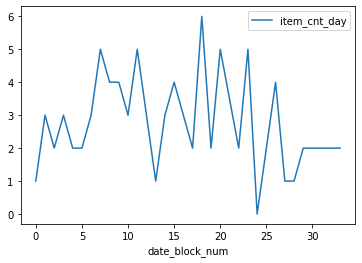

In [19]:
item_id = 4560
filtered_df = dataframe_per_item(item_id, sales_train)
filtered_df = filtered_df[['date_block_num', 'item_cnt_day']]
filtered_df.groupby('date_block_num').sum().plot()